In [25]:
import numpy as np
import pandas as pd 
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib notebook

The following query was run to select faint sources where the pm and parallax signal is likely not real:
    
    select
    sqrt(power(pmra,2) + power(pmdec,2)) as pm, 
    sqrt(  power(pmra,2)*power(pmra_error, 2)/(power(pmra,2) + power(pmdec,2)) +
    power(pmdec,2)*power(pmdec_error, 2)/(power(pmra,2) + power(pmdec,2)) +
    2*pmra*pmdec/(power(pmra,2) + power(pmdec,2))*pmra_pmdec_corr*pmra_error*pmdec_error) as pm_unc, 
    gaia.parallax_over_error, gaia.b
    from  gaiadr2.gaia_source as gaia
    where gaia.phot_g_mean_mag between 20.5 and 21 and gaia.astrometric_params_solved > 3 
    and phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_chi2_al/(astrometric_n_good_obs_al-5) < 1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))

In [78]:
faint = fits.getdata("faint_gaia_color_cuts-result.fits")

In [79]:
faint

FITS_rec([(1.7538207816220805, 2.0021865278806774, -1.1609968, -10.469268598925476),
       (4.8476962328454682, 2.1067469475413025, 0.98329955, 12.404714960149722),
       (6.843181654762212, 1.2964695661714678, -2.5116651, 7.3970687095783765),
       ...,
       (35.058702448477064, 1.7525389525818789, 0.082547732, 39.69197245485099),
       (11.236167500865992, 2.5493702848997968, -1.0825808, 13.784450891602079),
       (4.4698168255835746, 1.6048254622570932, 0.79478604, -6.9748872582831476)], 
      dtype=(numpy.record, [('pm', '>f8'), ('pm_unc', '>f8'), ('parallax_over_error', '>f4'), ('b', '>f8')]))

In [80]:
len(faint)

20568254

Lindegren et al. 2018 show (Table B.1) that the typical uncertainty in parallax for a G = 21 mag source is ~2 mas. Thus a SNR = 1 would correspond to a distance of ~500 pc (with higher SNR corresponding to smaller distances).

The vast, vast majority of the 20M sources selected above will not have $d < 500\,\mathrm{pc}$, meaning their parallax cannot be measured and the scatter in parallax for these sources provides an envelope on the systematic scatter in parallax SNR. We use the 99.997% (equivalent to 4 sigma for Gaussian distribution) to select the parallax cut.

*note* - this is a conservative cut as all the stars used to define this threshold do have a parallax, and the resulting distribution of parallax SNR will be biased slightly above 0 for this reason. However, the goal is to complete a conservative selection of stars, so this bias does not negatively reflect the result.

In [81]:
np.percentile(faint['parallax_over_error'], (0.003, 50, 99.997))

array([-5.23834337,  0.21172658,  7.9463474 ])

Attempting a similar cut for the proper motion SNR does not work, because stars as faint as 21 mag can still show a significant proper motion. The pm SNR at 99.997% is 75 for this subset of stars.

In [76]:
np.percentile(faint['pm']/faint['pm_unc'], (0.003, 50, 99.997))

array([  1.66359202e-02,   2.66656245e+00,   7.51298702e+01])

## Cuts for selecting stars

The above analysis suggests that selecting sources with a **PM SNR > 75** and a **parallax SNR > 8** will overwhelmingly select real stars for the ZTF star-galaxy catalog. 

Below we investigate whether there is any significant bias associated with parallax or proper motion measurements as a function of crowding (where we use galactic latitude as a proxy for crowding).

<IPython.core.display.Javascript object>


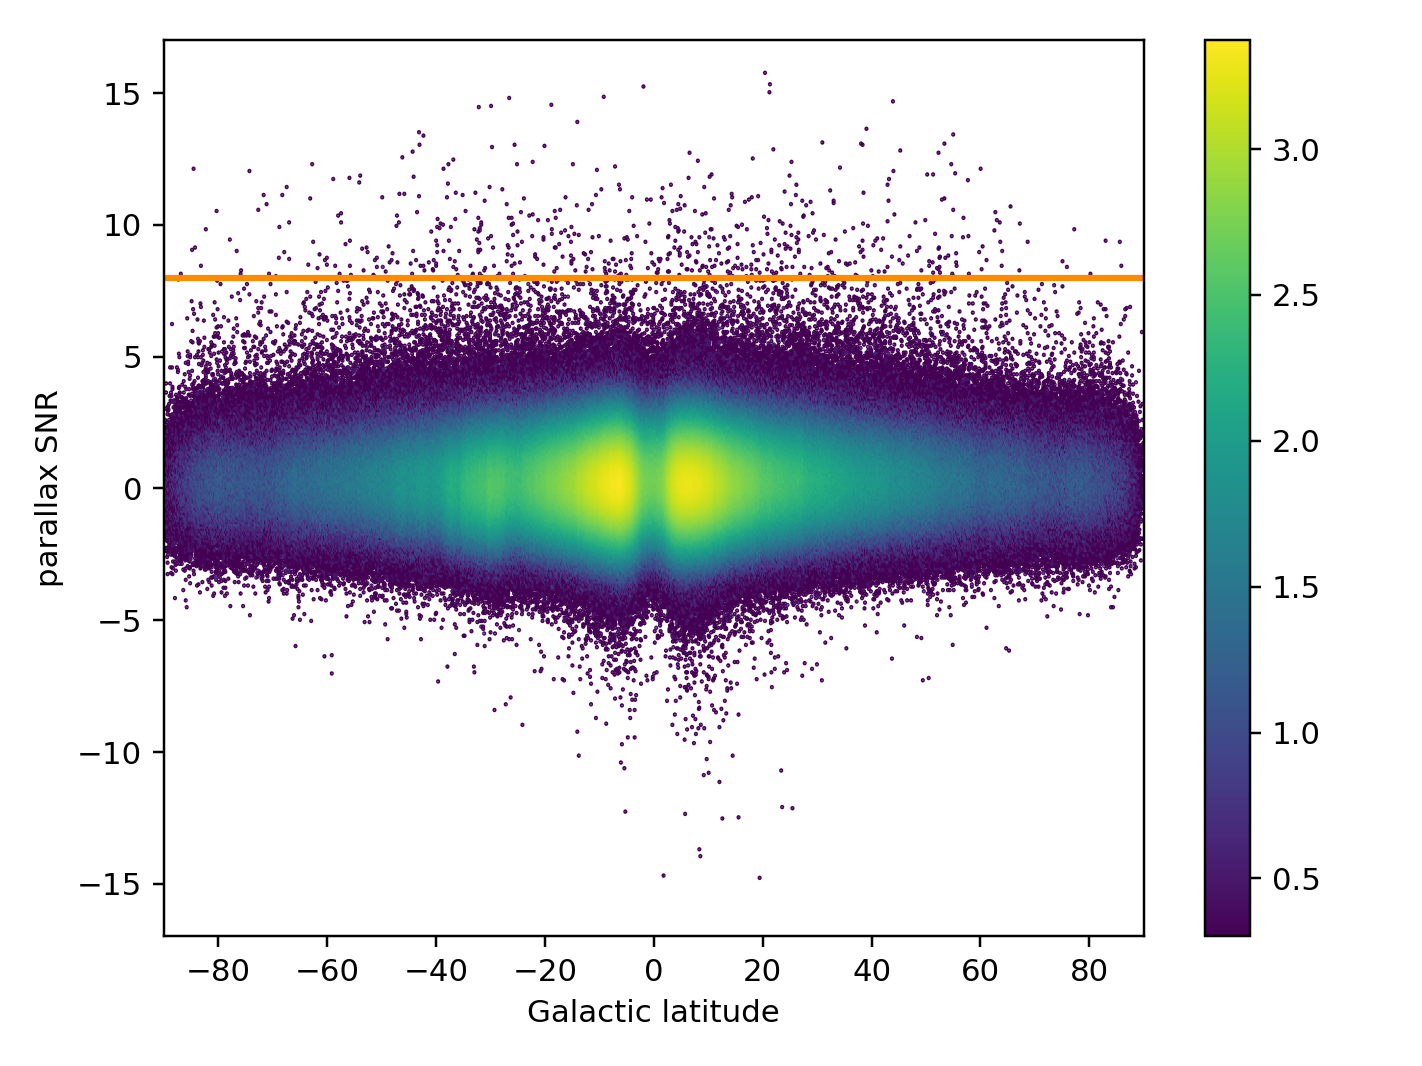

In [82]:
fig, ax = plt.subplots()
hax = ax.hexbin(faint["b"], faint["parallax_over_error"],
                bins="log", mincnt=1, gridsize=1000,
                extent=(-90,90,-25,25))
ax.plot([-90,90], [8,8], 'DarkOrange', lw=2)

ax.set_xlim(-90,90)
ax.set_ylim(-17,17)
ax.set_xlabel("Galactic latitude")
ax.set_ylabel("parallax SNR")

fig.colorbar(hax)
fig.tight_layout()

In [83]:
b = faint["b"]
pm_snr = faint["pm"]/faint["pm_unc"]

<IPython.core.display.Javascript object>


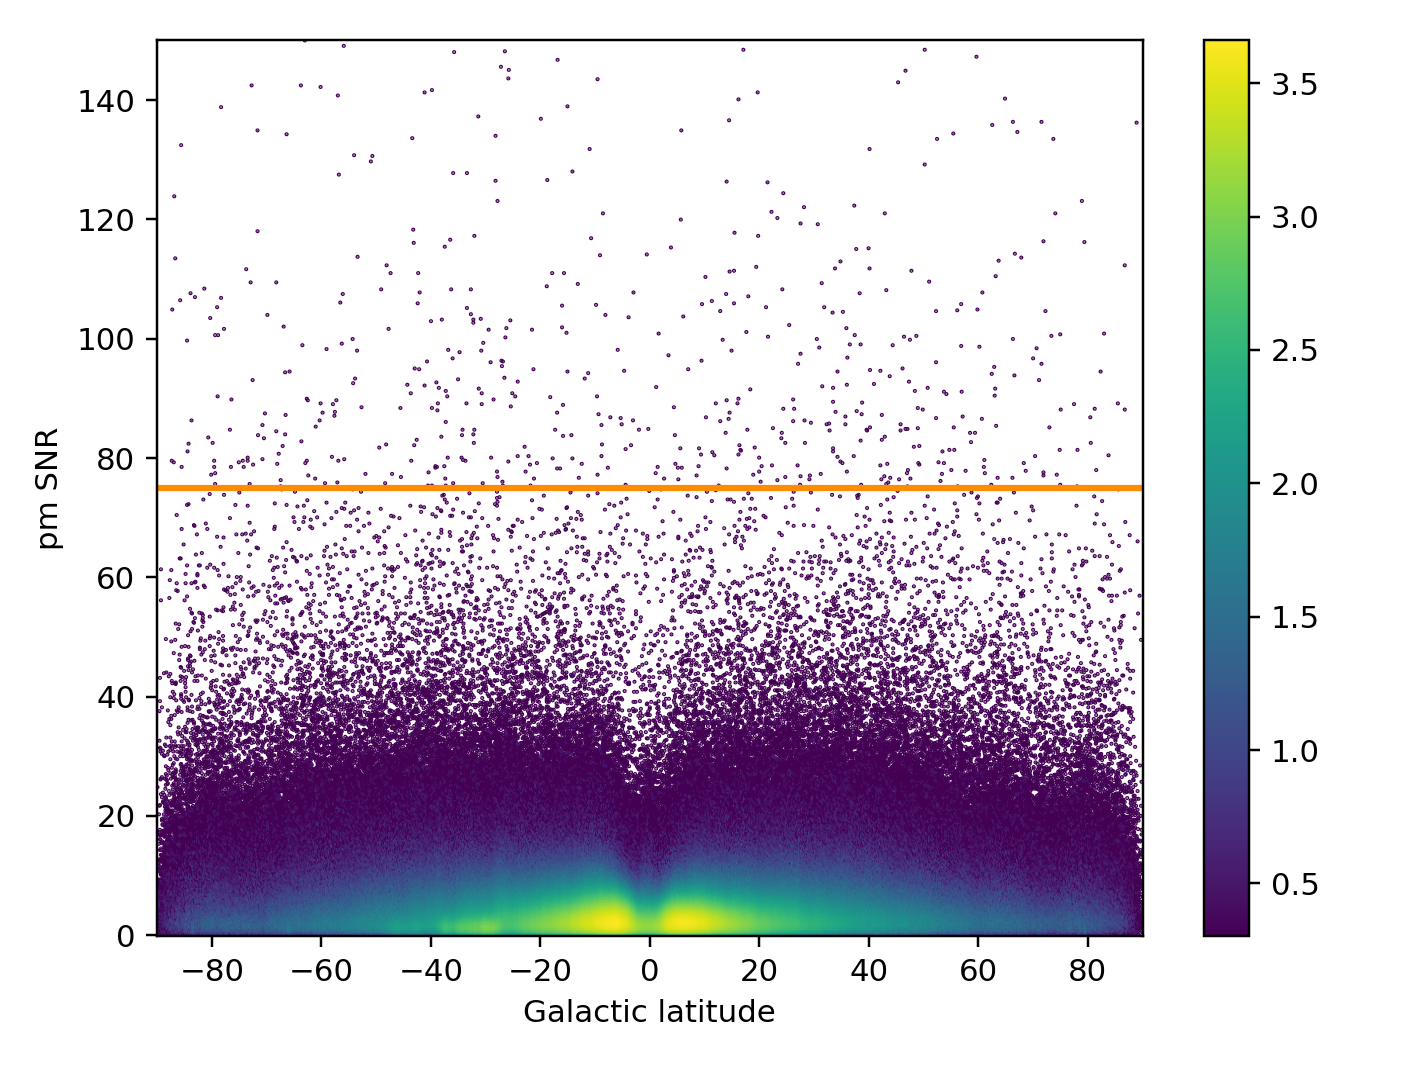

In [84]:
fig, ax = plt.subplots()
hax = ax.hexbin(b, pm_snr,
                bins="log", mincnt=1, gridsize=1000,
                extent=(-90,90,0,150))
ax.plot([-90,90], [75,75], 'DarkOrange', lw=2)

ax.set_xlim(-90,90)
ax.set_ylim(-0.2,150)
ax.set_xlabel("Galactic latitude")
ax.set_ylabel("pm SNR")

fig.colorbar(hax)
fig.tight_layout()

## ALLWISE AGN

In addition to looking at faint stars, a conservative cut could be made using QSOs (which should have negligible parallax and proper motion). 

In [Lindegren et al 2018](https://arxiv.org/pdf/1804.09366.pdf), Gaia DR2 is matched to ALLWISE QSOs away from the Galactic plane. Those sources can be selected from Gaia via the following cut: 

    select sqrt(power(pmra,2) + power(pmdec,2)) as pm, 
    sqrt(  power(pmra,2)*power(pmra_error, 2)/(power(pmra,2) + power(pmdec,2)) 
         + power(pmdec,2)*power(pmdec_error, 2)/(power(pmra,2) + power(pmdec,2)) 
         + 2*pmra*pmdec/(power(pmra,2) + power(pmdec,2))*pmra_pmdec_corr*pmra_error*pmdec_error) as pm_unc, 
    gaia.parallax_over_error, pmra/pmra_error as pmra_over_error, pmdec/pmdec_error as pmdec_over_error
    from  gaiadr2.gaia_source as gaia 
    join  gaiadr2.aux_allwise_agn_gdr2_cross_id as allwise
    on allwise.source_id = gaia.source_id

The AGN catalog provided by *Gaia* cannot be used for a cut on parallax, however, as anything with parallax SNR > 5 was excluded from this sample. These sources are a good way to cut on proper motion SNR, however, as they are so distant their proper motions should be very small.

In [85]:
allwise = fits.getdata("QSOcat-result.fits")

In [86]:
np.percentile(allwise['pm']/allwise['pm_unc'], (0.003, 50, 99.997, 100))

array([  7.02322432e-03,   1.22377578e+00,   5.61393208e+00,
         7.42790382e+00])

A cut of 7.5 on proper motion SNR would remove all AGN from the Lindegren AGN sample, and thus  we will adopt this to select stars in the data.

<IPython.core.display.Javascript object>


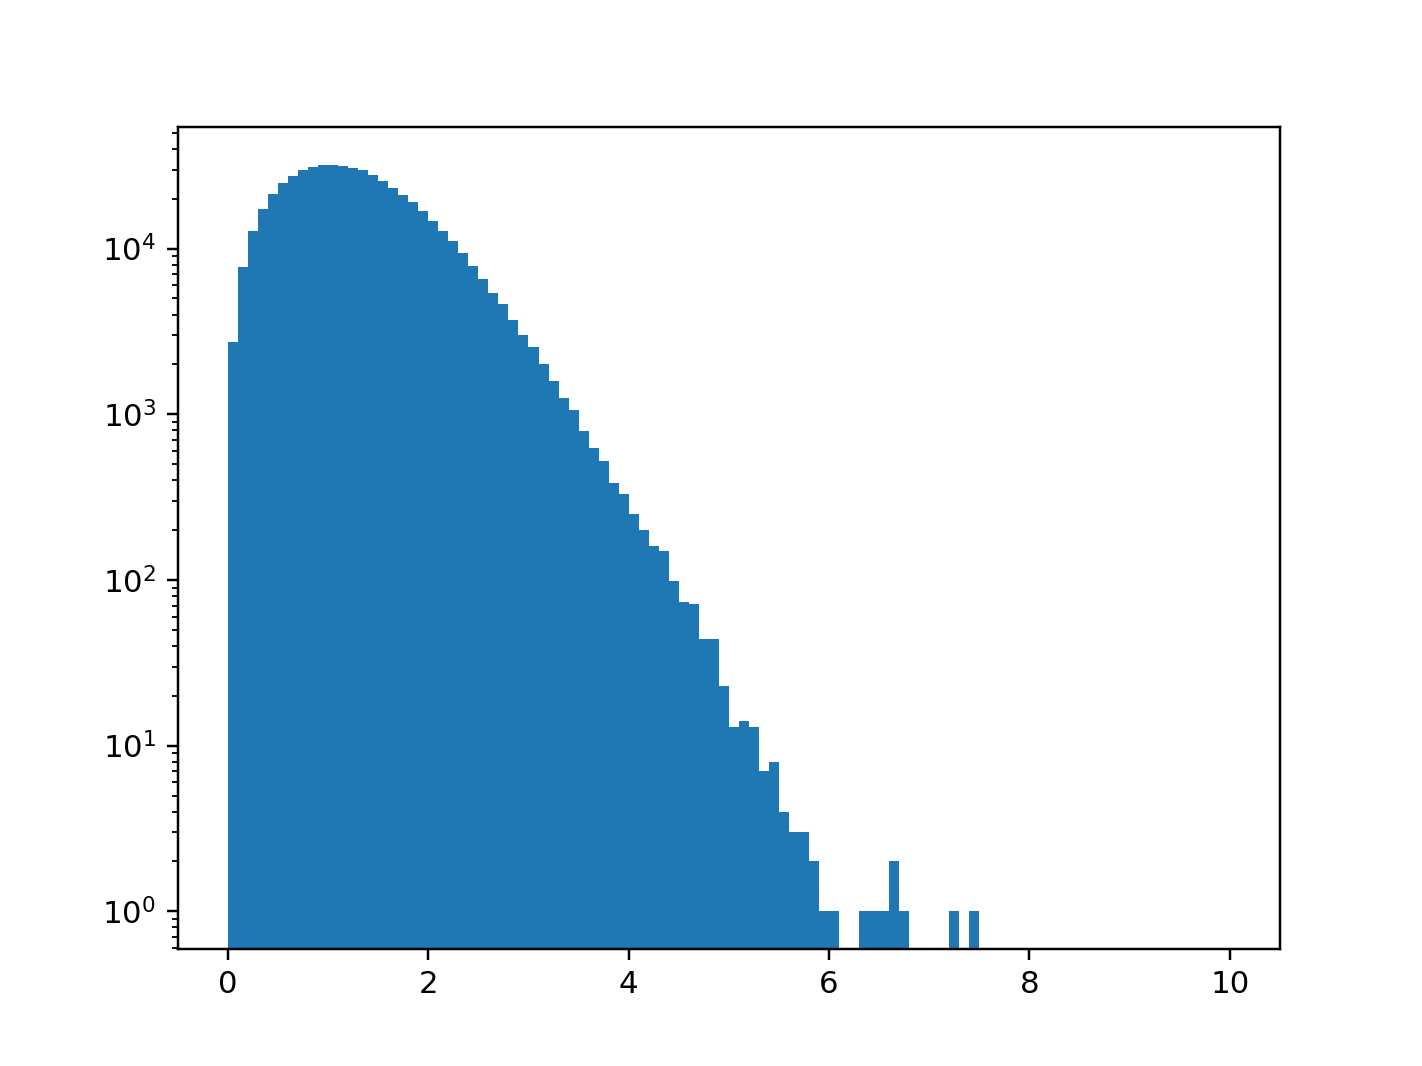

In [88]:
fig, ax = plt.subplots()
hax = ax.hist(allwise['pm']/allwise['pm_unc'],
        bins=100,range=(0,10))
ax.set_yscale("log")